# Cart Pole

CartPole is a game within the Open AI Gym environment whereby there exists a cart that has a pole attached to it. The cart moves along a frictionless track and the aim is to prevent the pole from falling over. The system is controlled by the application of a force of +1 and -1. A reward of +1 is assigned when the pole is upright at a new timestep. The episode concludes when the pole is more than 15 degrees from the vertical direction, or when the cart has moved a distance greater than 2.4 units. 

__Actions:__
1. Apply force of +1
2. Apply force of -1

__Termination Criteria:__
1. Pole has declined an angle greater than 15 degrees from upright position
2. Cart has traveled a distance grater than 2.4 units from the center

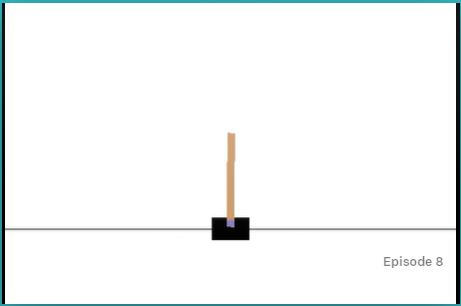
_The image above shows the Cart Pole game whereby there is the cart and the pole that stands on top of the cart. In the image, the cart is in an upright position, which is desirable._ Source: _Adapted from https://gym.openai.com/_


# Deep Q-Learning

__Deep Q-Learning__ is a technique for implementing Reinforcement Learning whereby neural networks are used. This method differs from the tabular Q-Learning technique in that instead of a Q-table, a neural network is responsible for outputting the Q-values for actions at a given state. There are 2 neural networks used in this method, a _policy network_ and a _target network_. The policy network is responsible for the Q-values and is the only network that is trained. The concept of _replay memory_ is introduced to guide the target network. The target network is not trained, but uses the weights from the policy network at specified intervals. Deep Q-Learning also makes use of the Temporal Difference Equation, as in Q-Learning.

The figure below depicts the basic idea of the Deep Q-Learning methodology. The state is passed as input to the neural network. The different layers in the network perform different functions, such as feature selection. The neural network outputs the Q-values for the different actions possible at the inputted state. Source: _www.perfectial.com_

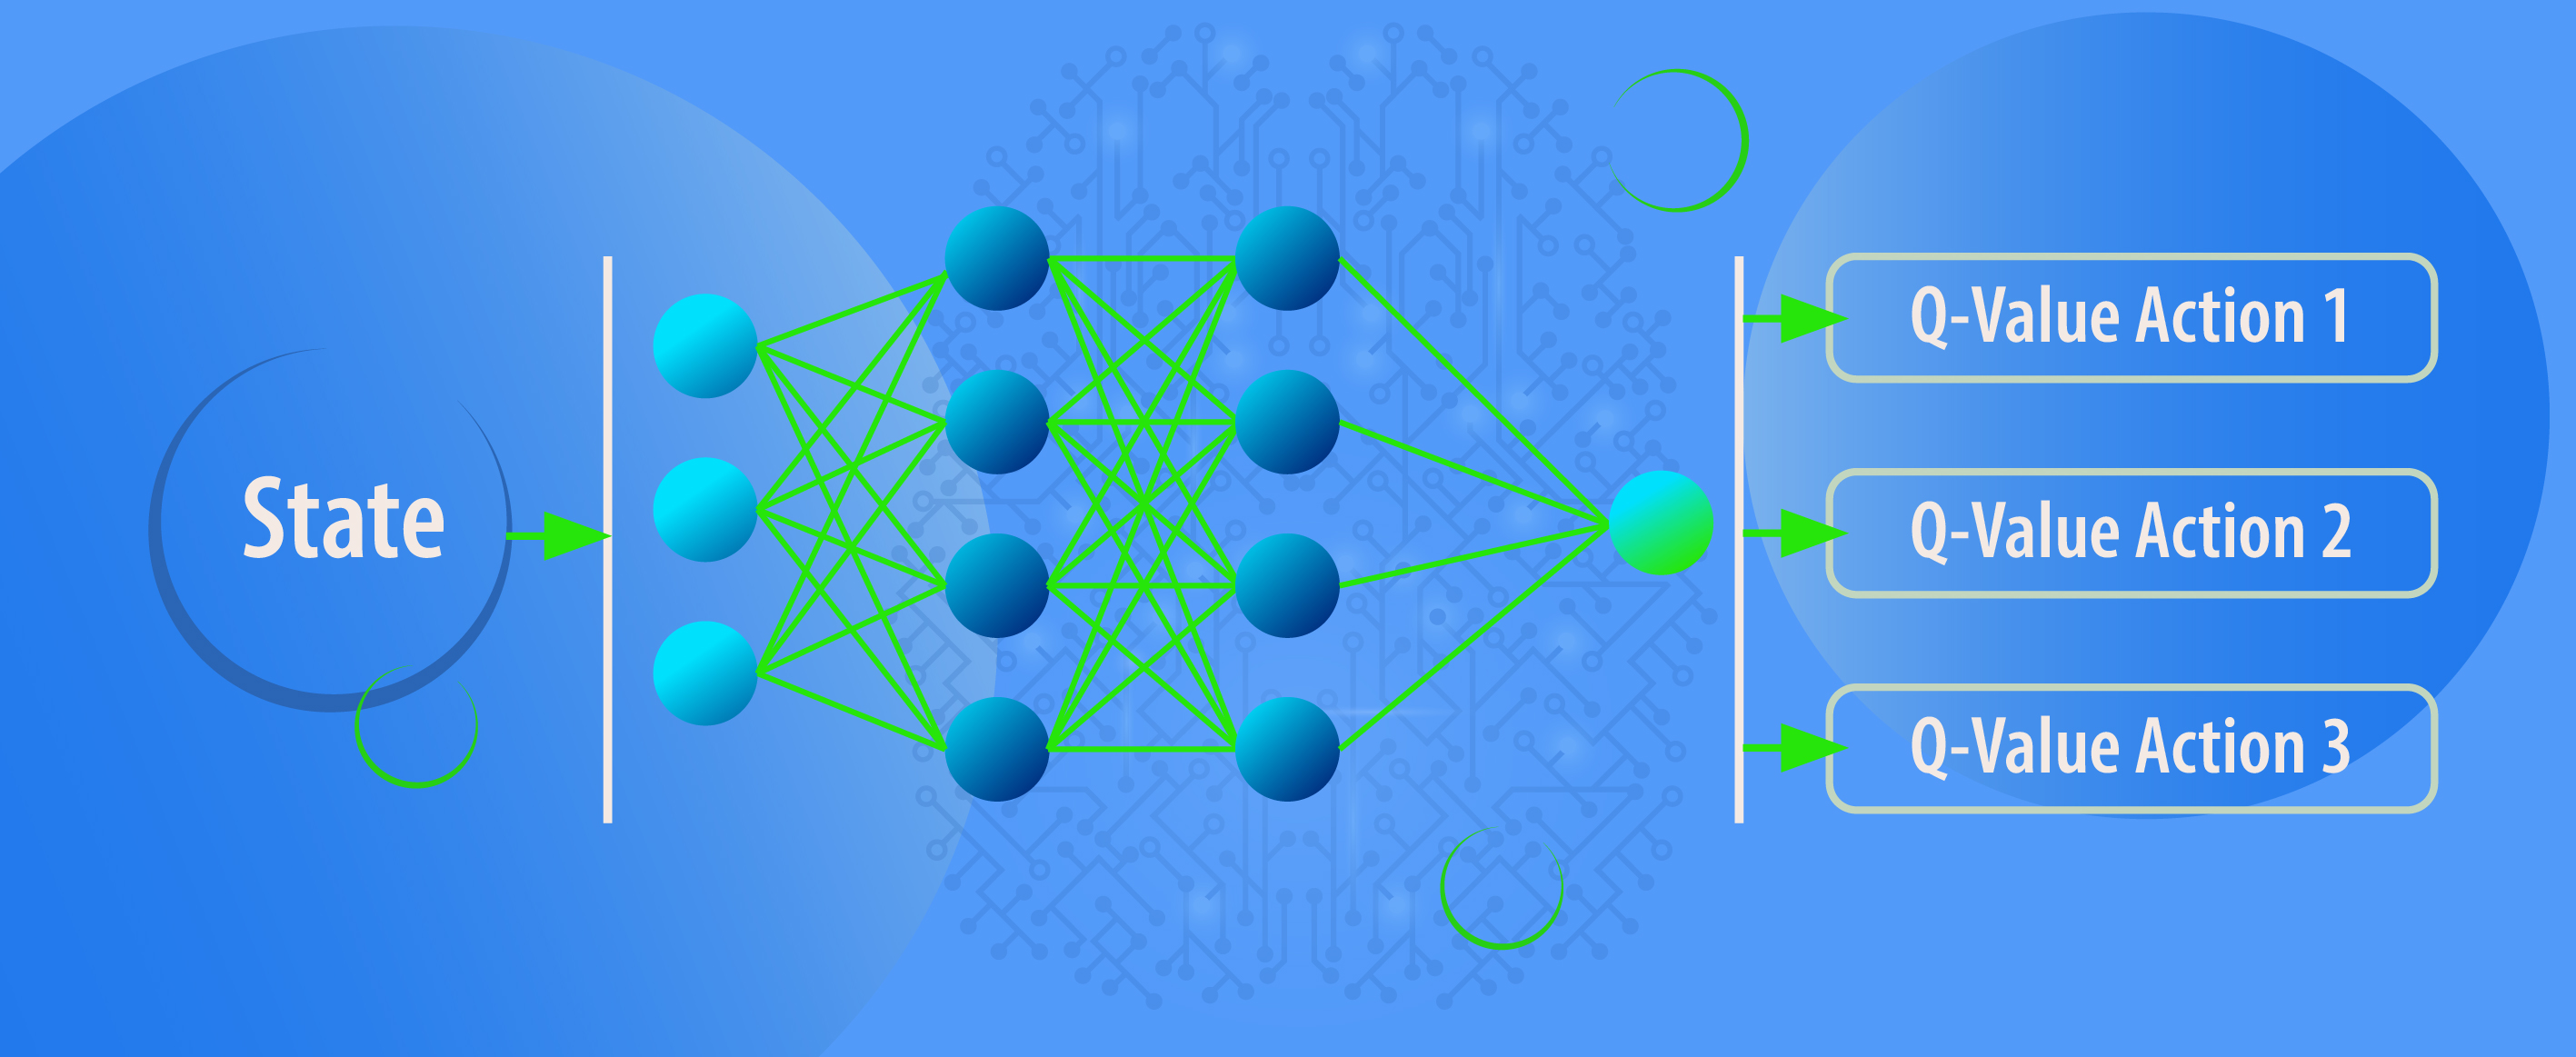

## Using Deep Q-Learning to solve the Cart Pole Problem

The first step is to make the necessary library imports. The Gym environment is used to define the CartPole game. NumPy is used for its mathematical processing. The Tensorflow library is used to implement machine learning models. 

In [40]:
import gym
import random
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from collections import deque
import warnings
warnings.filterwarnings('ignore')

The environment is created by using the AI Gym library. We can view the available actions by calling the env.action_space method.

In [41]:
env_name = "CartPole-v0"
env = gym.make(env_name)
env._max_episode_steps = 500
print("Possible Actions:", env.action_space)

Possible Actions: Discrete(2)


The Q-Network model is defined. The constructor specifies the input and output dimensions, i.e. states as input, and q-values as outputs. There is a hidden layer with 100 nodes and uses the ReLU (Rectified Linear Unit) Activation Function. The output is formulated using One-Hot Encoding. The output from the hidden layer is passed into another layer to produce a value for each possible action at the inputted states. This is then multiplied with the one-hot encoded vector to obtain the final results. 

In [42]:
class QNetwork():
    def __init__(self, state_n, action_n):
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_n])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.q_target_in = tf.placeholder(tf.float32, shape=[None])
        action_one_hot = tf.one_hot(self.action_in, depth=action_n)
        self.hidden_layer = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
        self.q_state = tf.layers.dense(self.hidden_layer, action_n, activation=None)
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state, action_one_hot), axis=1)
        self.loss = tf.reduce_mean(tf.square(self.q_state_action - self.q_target_in))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.0015).minimize(self.loss)
        
    def update_model(self, session, state, action, q_target):
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target}
        session.run(self.optimizer, feed_dict=feed)
        
    def get_q_state(self, session, state):
        q_state = session.run(self.q_state, feed_dict={self.state_in: state})
        return q_state

In order to enhance the learning process, replay memory is defined. Here a ReplayBuffer is used to model initial exploration of the agent. 

In [43]:
class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

The Agent class is defined. Here an object of the Q-Network model is created and initialized according to the state dimensions and the action dimensions. The get_action method returns an action for the particular state by making use of the initialized Q-Network. The train method is used to train the network.

In [44]:
class DQNAgent():
    def __init__(self, env):
        self.state_n = env.observation_space.shape
        self.action_n = env.action_space.n
        self.q_network = QNetwork(self.state_n, self.action_n)
        self.replay_buffer = ReplayBuffer(maxlen=10000)
        self.gamma = 0.97
        self.epsilon = 1.0
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def get_action(self, state):
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state)
        action_random = np.random.randint(self.action_n)
        action = action_random if random.random() < self.epsilon else action_greedy
        return action
    
    def train(self, state, action, next_state, reward, done):
        self.replay_buffer.add((state, action, next_state, reward, done))
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(50)
        q_next_states = self.q_network.get_q_state(self.sess, next_states)
        q_next_states[dones] = np.zeros([self.action_n])
        q_targets = rewards + self.gamma * np.max(q_next_states, axis=1)
        self.q_network.update_model(self.sess, states, actions, q_targets)
        
        if done: self.epsilon = max(0.1, 0.99*self.epsilon)
    
    def __del__(self):
        self.sess.close()

Now we will see how the agent performs after performing a number of episodes.

In [45]:
for it in range(1, 110):
    agent = DQNAgent(env)
    num_episodes = it

    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.train(state, action, next_state, reward, done)
            env.render()
            total_reward += reward
            state = next_state
        
        #print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
        
    sum = 0
    for i in range(15):
        t = 0
        done = False
        state = env.reset()
        while not done:
            t = t+1
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.train(state, action, next_state, reward, done)
            env.render()
            state = next_state
        #print(t)
        sum += t
    
    avg = sum / 15
    print('Training Episodes: ', it, ', Avg Score: ', avg)
          

Training Episodes:  1 , Avg Score:  18.6
Training Episodes:  2 , Avg Score:  22.733333333333334
Training Episodes:  3 , Avg Score:  21.466666666666665
Training Episodes:  4 , Avg Score:  21.466666666666665
Training Episodes:  5 , Avg Score:  24.4
Training Episodes:  6 , Avg Score:  21.6
Training Episodes:  7 , Avg Score:  25.666666666666668
Training Episodes:  8 , Avg Score:  27.933333333333334
Training Episodes:  9 , Avg Score:  24.0
Training Episodes:  10 , Avg Score:  18.933333333333334
Training Episodes:  11 , Avg Score:  15.333333333333334
Training Episodes:  12 , Avg Score:  23.933333333333334
Training Episodes:  13 , Avg Score:  22.733333333333334
Training Episodes:  14 , Avg Score:  20.666666666666668
Training Episodes:  15 , Avg Score:  29.333333333333332
Training Episodes:  16 , Avg Score:  18.133333333333333
Training Episodes:  17 , Avg Score:  30.0
Training Episodes:  18 , Avg Score:  22.066666666666666
Training Episodes:  19 , Avg Score:  35.86666666666667
Training Episode

Exception ignored in: <function Viewer.__del__ at 0x0000021098352550>
Traceback (most recent call last):
  File "c:\users\ameeth_s\appdata\local\programs\python\python39\lib\site-packages\gym\envs\classic_control\rendering.py", line 185, in __del__
    self.close()
  File "c:\users\ameeth_s\appdata\local\programs\python\python39\lib\site-packages\gym\envs\classic_control\rendering.py", line 101, in close
    self.window.close()
  File "c:\users\ameeth_s\appdata\local\programs\python\python39\lib\site-packages\pyglet\window\win32\__init__.py", line 328, in close
    super(Win32Window, self).close()
  File "c:\users\ameeth_s\appdata\local\programs\python\python39\lib\site-packages\pyglet\window\__init__.py", line 857, in close
    app.windows.remove(self)
  File "c:\users\ameeth_s\appdata\local\programs\python\python39\lib\_weakrefset.py", line 110, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x00000210A5050400; to 'Win32Window' at 0x00000210A3041D30>
Exception ignore

Training Episodes:  57 , Avg Score:  144.86666666666667
Training Episodes:  58 , Avg Score:  64.73333333333333
Training Episodes:  59 , Avg Score:  134.53333333333333
Training Episodes:  60 , Avg Score:  102.66666666666667
Training Episodes:  61 , Avg Score:  238.06666666666666
Training Episodes:  62 , Avg Score:  117.13333333333334
Training Episodes:  63 , Avg Score:  86.4
Training Episodes:  64 , Avg Score:  160.4
Training Episodes:  65 , Avg Score:  166.6
Training Episodes:  66 , Avg Score:  97.53333333333333
Training Episodes:  67 , Avg Score:  100.33333333333333
Training Episodes:  68 , Avg Score:  191.53333333333333
Training Episodes:  69 , Avg Score:  201.8
Training Episodes:  70 , Avg Score:  182.6
Training Episodes:  71 , Avg Score:  190.4
Training Episodes:  72 , Avg Score:  116.86666666666666
Training Episodes:  73 , Avg Score:  196.4
Training Episodes:  74 , Avg Score:  124.93333333333334
Training Episodes:  75 , Avg Score:  207.93333333333334
Training Episodes:  76 , Avg S